In [22]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [16, 8]
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [23]:
# All variables we care about
FcolumnNames1999_2007 = ['releaseNum', 'familyID', 'composition', 'headCount', 'ageHead', 'maritalStatus', 'own', 
                         'employmentStatus', 'liquidWealth', 'race', 'industry','incomeHead', "incomeWife", 
               'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education', 
               'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', "wealthWithHomeEquity"]

FcolumnNames2009_2017 = ['releaseNum', 'familyID', 'composition', 'headCount', 'ageHead', 'maritalStatus', 'own', 
                         'employmentStatus', 'liquidWealth', 'race', 'industry' ,'incomeHead', 'incomeWife', 
               'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity',
               'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education']

FcolumnNames2019 = ['releaseNum', 'familyID', 'composition', 'headCount', 'ageHead', 'maritalStatus', 'own', 
                         'employmentStatus', 'liquidWealth_bank', 'liquidWealth_bond', 'race', 'industry' ,'incomeHead', 'incomeWife', 
               'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity',
               'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education']

# The timeline we care about
years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]

In [24]:
def Fcompile_data_with_features(features, years = years):
    df = pd.DataFrame()
    # Loading the data through years
    for year in years:
        df_sub = pd.read_csv(str(year) + ".csv")
        if year >= 1999 and year <= 2007:
            df_sub.columns = FcolumnNames1999_2007
        elif year >= 2009 and year <= 2017:
            df_sub.columns = FcolumnNames2009_2017
        else:
            # In the year 2019, the liquid wealth equals to liquidWealth in cash and liquid bond
            df_sub.columns = FcolumnNames2019
            df_sub["liquidWealth"] = df_sub['liquidWealth_bank'] + df_sub['liquidWealth_bond']
        df_sub['year'] = year
        df = pd.concat([df, df_sub[['familyID','year'] + features]])
    df = df.reset_index(drop = True)
    return df

# The function is used to drop the values we do not like in the dataFrame, 
# the input "features" and "values" are both list
def drop_values(features, values, df): 
    for feature in features:
        for value in values:
            df = df[df[feature] != value]
    df = df.reset_index(drop = True)
    return df

In [25]:
# prepare the combined dataset and set up dummy variables for qualitative data
df = Fcompile_data_with_features(['composition', 'headCount', 'ageHead', 'maritalStatus', 'own',
                                  'employmentStatus', 'liquidWealth', 'race', 'industry','incomeHead', 'incomeWife', 
                                  'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education', 
                                  'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity'], years)

In [26]:
# data clean, drop NA/DK values
df = drop_values(["ageHead"],[999], df)
df = drop_values(["maritalStatus"],[8,9], df)
df = drop_values(["own"],[8,9], df)
df = drop_values(["employmentStatus"],[0,22,8,98, 99], df)
df = drop_values(["liquidWealth"],[999999998,999999999,-400], df)
df = drop_values(["race"],[0,8,9], df)
df = drop_values(["industry"],[999,9999,0], df)
df = drop_values(["education"],[99,0], df)
# calculate the aggregate variables 
df["totalExpense"] = df[['foodCost', 'houseCost', 'transCost', 
                                      'educationCost', 'childCost', 'healthCost']].sum(axis = 1)
df["laborIncome"] = df["incomeHead"] + df["incomeWife"]
df["costPerPerson"] = df["totalExpense"]/df["headCount"]
df["HomeEquity"] = df["wealthWithHomeEquity"] - df["wealthWithoutHomeEquity"]

In [27]:
maritalStatus = ["Married", "neverMarried", "Widowed", "Divorced", "Separated"]
employmentStatus = ["Working", "temporalLeave", "unemployed", "retired", "disabled", "keepHouse", "student", "other"]
race = ["White", "Black","AmericanIndian","Asian","Latino","otherBW","otherRace"]
# Education
# < 8th grade: middle school
# >= 8 and < 12: high scho0l
# >=12 and < 15: college
# >= 15 post graduate
education = ["middleSchool", "highSchool", "college", "postGraduate"]
# Industry
# < 400 manufacturing
# >= 400 and < 500 publicUtility
# >= 500 and < 680 retail 
# >= 680 and < 720 finance
# >= 720 and < 900 service
# >= 900 otherIndustry
industry = ["finance", "noneFinance"]
ownership = ["owner", "renter"]

data = []
for i in tqdm(range(len(df))):
    dataCollect = []
    # marital status
    dataCollect.append(maritalStatus[int(df.iloc[i]["maritalStatus"]-1)])
    # employment
    dataCollect.append(employmentStatus[int(df.iloc[i]["employmentStatus"]-1)])
    # race
    dataCollect.append(race[int(df.iloc[i]["race"] - 1)])
    # Education variable 
    if df.iloc[i]["education"] < 8:
        dataCollect.append(education[0])
    elif df.iloc[i]["education"] >= 8 and df.iloc[i]["education"] < 12:
        dataCollect.append(education[1])
    elif df.iloc[i]["education"] >= 12 and df.iloc[i]["education"] < 15:
        dataCollect.append(education[2])
    else:
        dataCollect.append(education[3])
    # industry variable 
    if df.iloc[i]["year"] in [1999, 2001]:
        if df.iloc[i]["industry"] >= 707 and df.iloc[i]["industry"] <= 718:
            dataCollect.append(industry[0])
        else:
            dataCollect.append(industry[1])
    elif df.iloc[i]["year"] in [2003,2005,2007,2009,2011,2013,2015,2015]:
        if df.iloc[i]["industry"] >= 687 and df.iloc[i]["industry"] <= 699:
            dataCollect.append(industry[0])
        else:
            dataCollect.append(industry[1])        
    else:
        if df.iloc[i]["industry"] >= 6870 and df.iloc[i]["industry"] <= 6990:
            dataCollect.append(industry[0])
        else:
            dataCollect.append(industry[1])
    # ownership status 
    if df.iloc[i]["own"] == 1:
        dataCollect.append(ownership[0])
    else:
        dataCollect.append(ownership[1])
    data.append(dataCollect)
# Categorical dataFrame
df_cat = pd.DataFrame(data, columns = ["maritalStatus", "employmentStatus", "race", "education", "industry", "ownership"])

Fdf = pd.concat([df[["familyID", "year",'composition', 'headCount', 'ageHead', 'liquidWealth', 'laborIncome', 
                     "costPerPerson","totalExpense", 'participation', 'investmentAmount', 'annuityIRA', 
                                 'wealthWithoutHomeEquity', "wealthWithHomeEquity", "HomeEquity"]], 
                          df_cat[["maritalStatus", "employmentStatus", "education","race", "industry", "ownership"]]], axis=1)
# simplify the employment status to working retired and unemployed
Fdf.loc[(Fdf["employmentStatus"] != "Working")&(Fdf["employmentStatus"] != "retired"), "employmentStatus"] = "unemployed"
Fdf.loc[Fdf["employmentStatus"]=="Working", "employmentStatus"] = "employed"

100%|██████████| 69692/69692 [02:43<00:00, 426.25it/s]


In [28]:
# Adjust for inflation, all values are in thousand dollor
years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]
values_at2020 = np.array([1.55, 1.46, 1.40, 1.32, 1.24, 1.20, 1.15, 1.11, 1.09, 1.05, 1.01])
values_at2005 = values_at2020/1.32
quantVariables = ['annuityIRA', 'investmentAmount', 'liquidWealth', 'laborIncome', 'costPerPerson',
                 'totalExpense', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity', "HomeEquity"]
for i in tqdm(range(len(Fdf))):
    for variable in quantVariables:
        Fdf.loc[i, variable] = round(Fdf.loc[i, variable] * values_at2005[years.index(Fdf.loc[i,"year"])] / 1000, 2)

# roughly drop the outliers 
for var in quantVariables:
    Fdf = Fdf[Fdf[var] < Fdf[var].quantile(0.99)]
# only cares about people older than 20 and younger that 80
Fdf = Fdf[(Fdf["ageHead"] >= 20) & (Fdf["ageHead"] <= 80)]
Fdf.shape

100%|██████████| 69692/69692 [06:20<00:00, 183.27it/s]


(61801, 21)

### Group population into 4 types of agents

In [29]:
# define new dfs refering to 4 types of agents
lowSkill = ["middleSchool", "highSchool"]
highSkill = ["college", "postGraduate"]
highFinance = Fdf[(Fdf["education"].isin(highSkill)) & (Fdf["industry"] == "finance")]
lowFinance = Fdf[(Fdf["education"].isin(lowSkill)) & (Fdf["industry"] == "finance")]
highNoneFinance = Fdf[(Fdf["education"].isin(highSkill)) & (Fdf["industry"] == "noneFinance")]
lowNoneFinance = Fdf[(Fdf["education"].isin(lowSkill)) & (Fdf["industry"] == "noneFinance")]

Fdf["skillLevel"] = "High"
Fdf.loc[Fdf["education"].isin(lowSkill), "skillLevel"] = "Low"
Fdf["financeExperience"] = "No"
Fdf.loc[Fdf["industry"] == "finance", "financeExperience"] = "Yes"

# define the age groups and decade groups 
Fdf["ageGroup"] = "20"
Fdf["decadeGroup"] = "90's"
for i in range(2,8,2):
    Fdf.loc[Fdf["ageHead"] >= i*10, "ageGroup"] = str(i*10)
for year in range(1990,2020,10):
    Fdf.loc[Fdf["year"] >= year, "decadeGroup"] = str(year) + "s"
# redefine the age groups 
Fdf.loc[Fdf["ageGroup"]== "20", "ageGroup"] = "20-40"
Fdf.loc[Fdf["ageGroup"]== "40", "ageGroup"] = "40-60"
Fdf.loc[Fdf["ageGroup"]== "60", "ageGroup"] = "60-80"

In [30]:
Fdf.head()

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,maritalStatus,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup
0,3,1999,2,1,76,2.35,0.00,7.30,7.30,0,...,Widowed,retired,middleSchool,White,noneFinance,owner,Low,No,60-80,1990s
1,2,1999,0,4,47,0.00,26.14,4.17,16.68,1,...,Married,employed,highSchool,White,noneFinance,owner,Low,No,40-60,1990s
2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,1,...,Divorced,employed,college,White,finance,owner,High,Yes,40-60,1990s
3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,0,...,Divorced,employed,college,White,noneFinance,owner,High,No,20-40,1990s
4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,0,...,Married,employed,highSchool,White,noneFinance,owner,Low,No,20-40,1990s


In [31]:
Fdf.tail()

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,maritalStatus,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup
69687,2534,2019,1,4,39,0.00,9.18,4.27,17.08,0,...,neverMarried,unemployed,college,Black,noneFinance,renter,High,No,20-40,2010s
69688,2162,2019,0,1,27,0.00,3.64,11.40,11.40,0,...,neverMarried,employed,college,Black,noneFinance,renter,High,No,20-40,2010s
69689,9011,2019,1,1,59,0.38,19.13,23.71,23.71,0,...,Divorced,employed,college,Black,noneFinance,renter,High,No,40-60,2010s
69690,9317,2019,8,2,61,0.00,0.00,3.91,7.83,0,...,Divorced,unemployed,college,Black,finance,renter,High,Yes,60-80,2010s
69691,3682,2019,0,4,39,6.12,112.17,11.42,45.67,0,...,Married,employed,college,Black,noneFinance,owner,High,No,20-40,2010s


In [32]:
Fdf.to_csv("familyData.csv")

### Generate summary plot

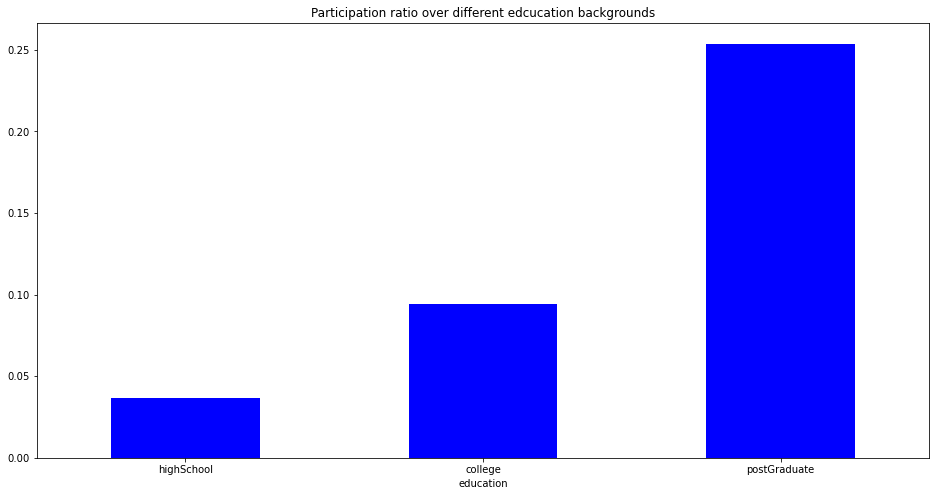

In [33]:
Fdf = pd.read_csv("familyData.csv")
plt.title("Participation ratio over different edcucation backgrounds")
Fdf.loc[Fdf["education"]=="middleSchool", "education"] = "highSchool"
Fdf.groupby("education").participation.mean().reindex(["highSchool", "college", "postGraduate"]).plot.bar(color = "blue",rot=0)
savefig('educationParticipation.jpg')

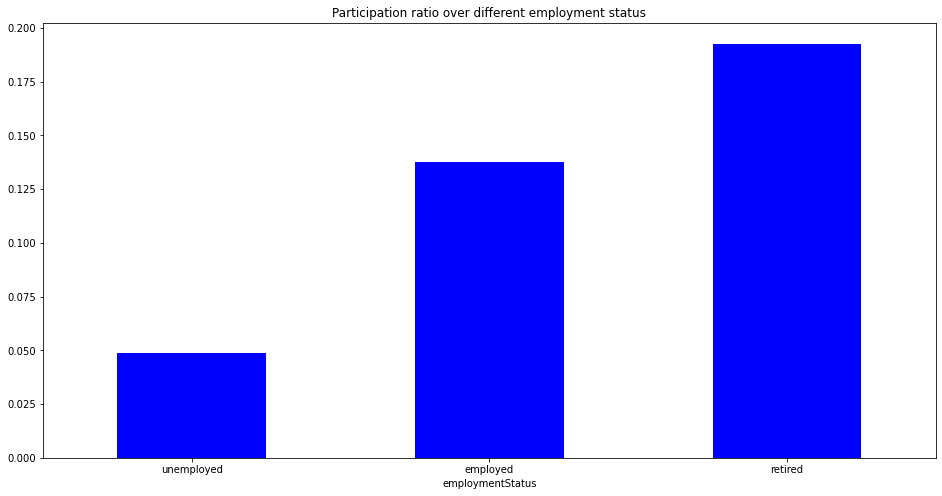

In [34]:
Fdf.loc[Fdf["employmentStatus"]=="Working", "employmentStatus"] = "employed"
plt.title("Participation ratio over different employment status")
Fdf.groupby("employmentStatus").participation.mean().reindex(["unemployed", "employed", "retired"]).plot.bar(color = "blue",rot=0)
savefig('employmentParticipation.jpg')

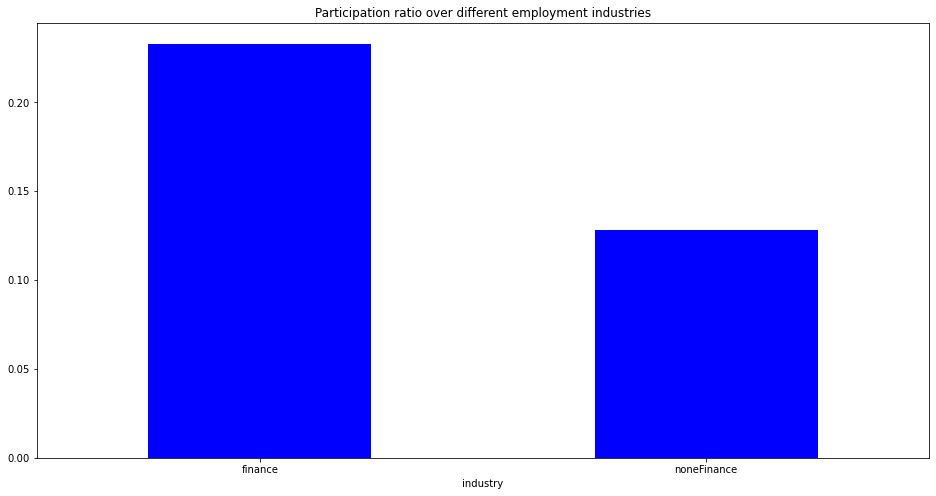

In [36]:
plt.title("Participation ratio over different employment industries")
Fdf.groupby("industry").participation.mean().plot.bar(color = "blue",rot=0)
savefig('industryParticipation.jpg')

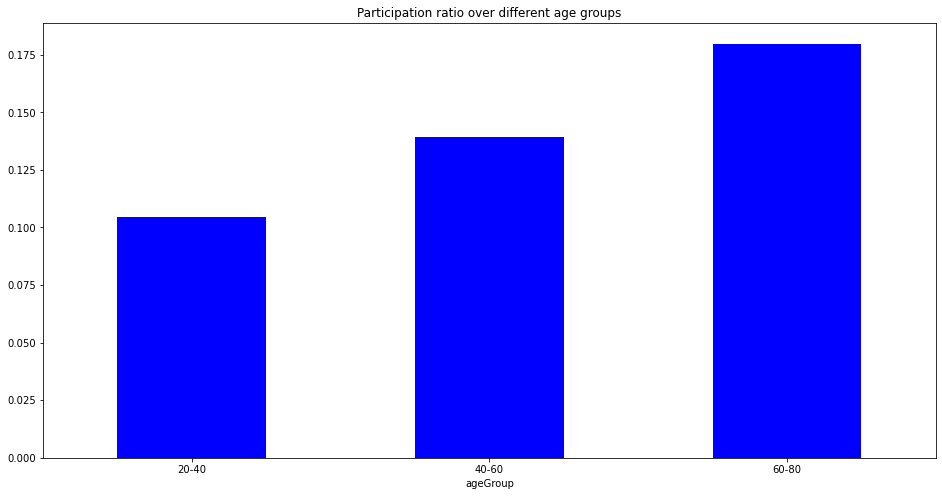

In [62]:
plt.title("Participation ratio over different age groups")
Fdf.groupby("ageGroup").participation.mean().plot.bar(color = "blue",rot=0)
savefig('ageParticipation.jpg')

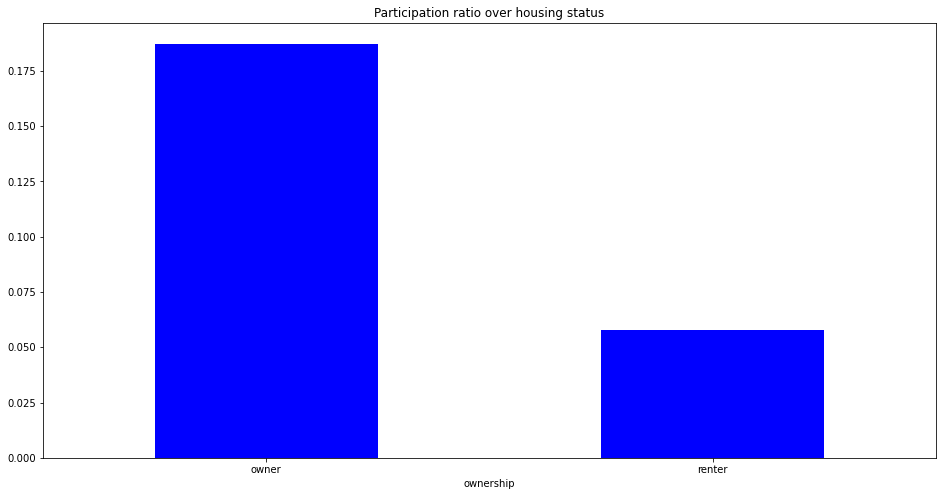

In [88]:
plt.title("Participation ratio over housing status")
Fdf.groupby("ownership").participation.mean().plot.bar(color = "blue",rot=0)
savefig('ownership.jpg')

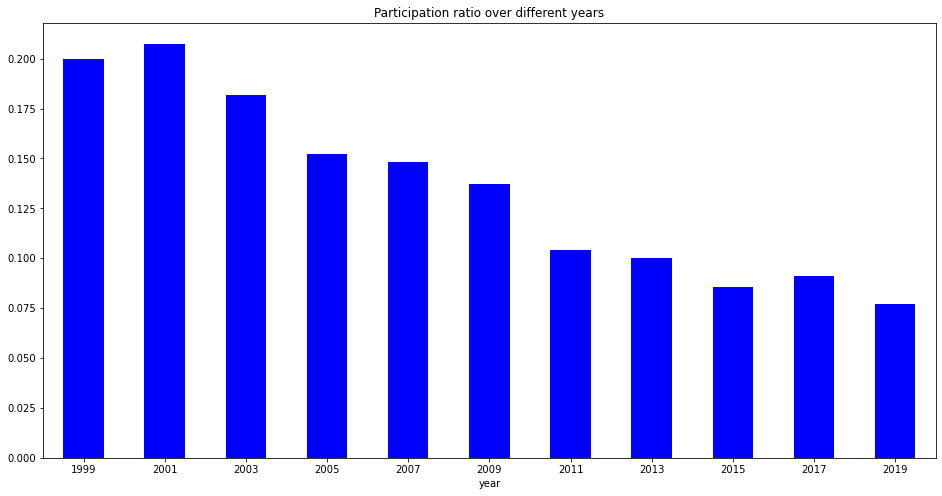

In [89]:
plt.title("Participation ratio over different years")
Fdf.groupby("year").participation.mean().plot.bar(color = "blue",rot=0)
savefig('year.jpg')

In [90]:
from scipy.signal import savgol_filter
lowIncome = Fdf[(Fdf.education == 'highSchool')|(Fdf.education == 'college')].groupby("ageHead")['laborIncome'].mean().values
highIncome = Fdf[Fdf.education == 'postGraduate'].groupby("ageHead")['laborIncome'].mean().values
highIncomeSmooth = savgol_filter(highIncome,window_length=9,polyorder=1)
lowIncomeSmooth = savgol_filter(lowIncome,window_length=9,polyorder=1)
ages = list(range(20,81))

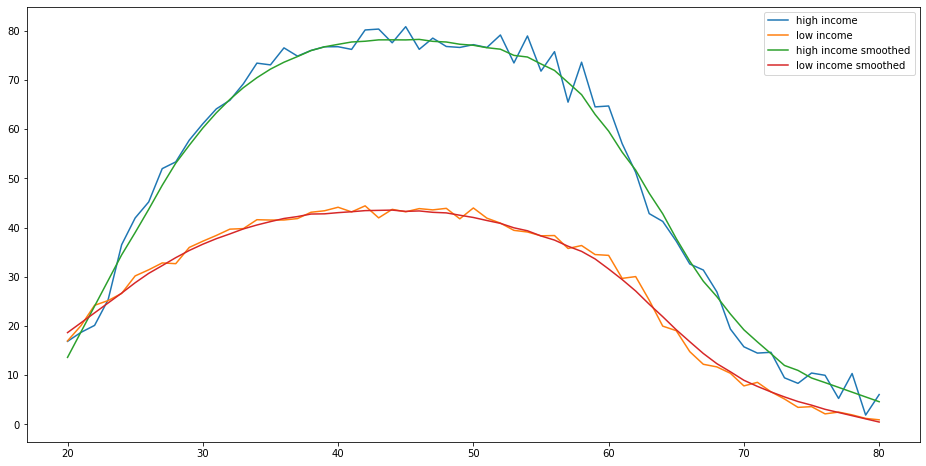

In [91]:
plt.plot(ages, highIncome, label = "high income")
plt.plot(ages, lowIncome, label = "low income")
plt.plot(ages, highIncomeSmooth, label = "high income smoothed")
plt.plot(ages, lowIncomeSmooth, label = "low income smoothed")
plt.legend()

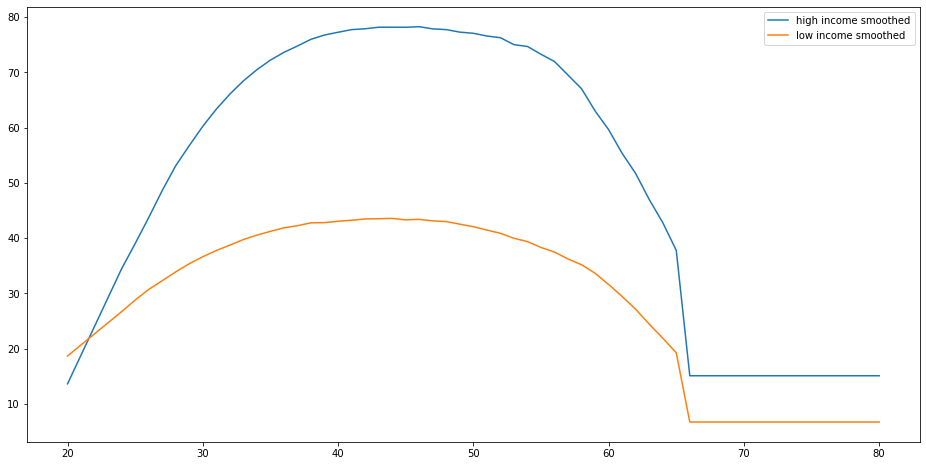

In [92]:
highIncomeSmooth[46:] = np.mean(highIncomeSmooth[46:])
lowIncomeSmooth[46:] = np.mean(lowIncomeSmooth[46:])
plt.plot(ages, highIncomeSmooth, label = "high income smoothed")
plt.plot(ages, lowIncomeSmooth, label = "low income smoothed")
plt.legend()

In [95]:
np.save("../shutDownRetirement/constant/highIncomeDetermined", highIncomeSmooth)
np.save("../shutDownRetirement/constant/lowIncomeDetermined", lowIncomeSmooth)

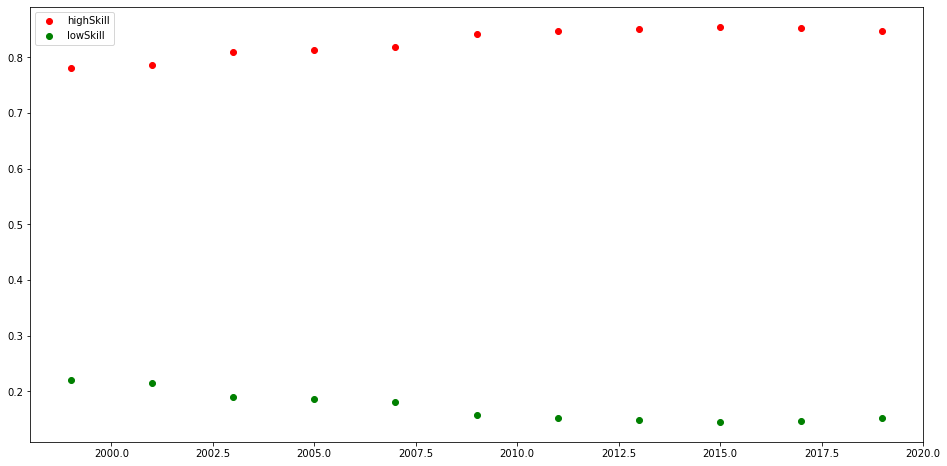

In [74]:
highSkillRatios = []
lowSkillRatios = []
for year in years:
    highRatio = Fdf[(Fdf["year"] == year)&(Fdf["skillLevel"] == "High")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    lowRatio = Fdf[(Fdf["year"] == year)&(Fdf["skillLevel"] == "Low")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    highSkillRatios.append(highRatio)
    lowSkillRatios.append(lowRatio)
    highSkill = plt.scatter(year, highRatio, color = 'r')
    lowSkill = plt.scatter(year, lowRatio, color = 'g')
plt.legend((highSkill,lowSkill), ("highSkill", "lowSkill"))

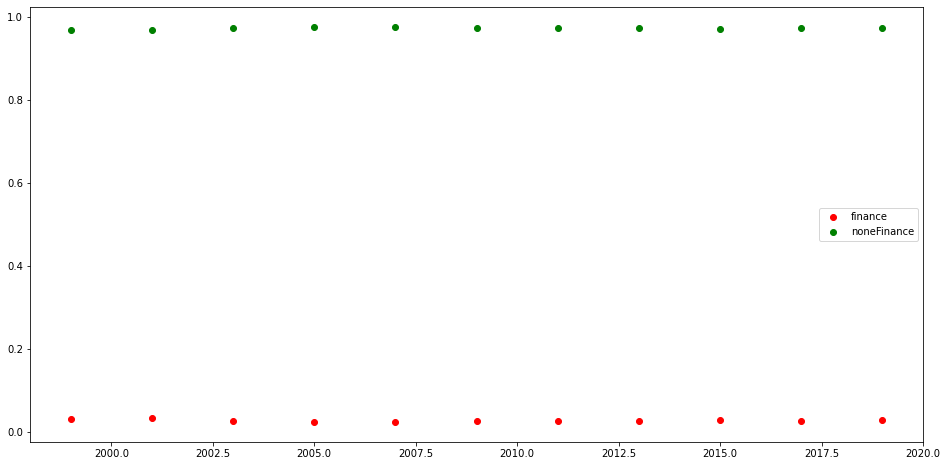

In [98]:
financeRatios = []
noneFinanceRatios= []
for year in years:
    fRatio = Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "Yes")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    nfRatio =  Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "No")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    financeRatios.append(fRatio)
    noneFinanceRatios.append(nfRatio)
    finance = plt.scatter(year, fRatio, color = 'r')
    noneFinance = plt.scatter(year, nfRatio, color = 'g')
plt.legend((finance,noneFinance), ("finance", "noneFinance"))

### empirical classes (richHigh, richLow, poorHigh, poorLow)

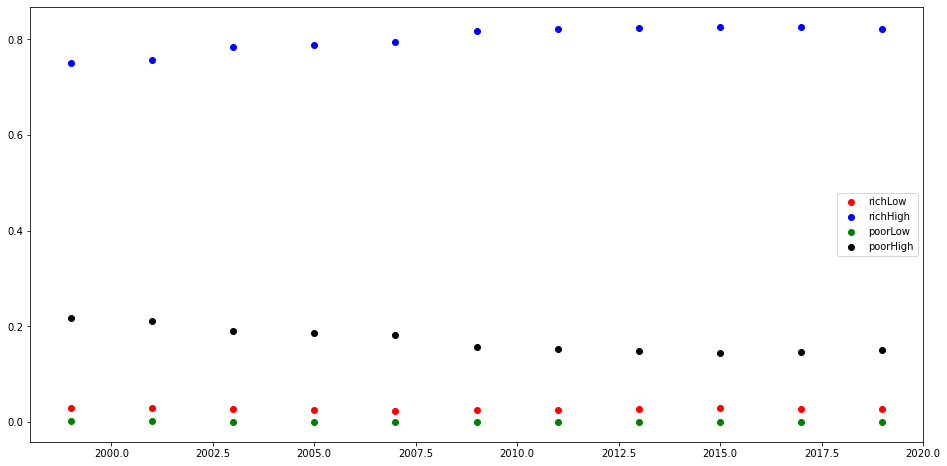

In [99]:
richHighRatios = []
richLowRatios = []
poorHighRatios = []
poorLowRatios = []
for year in years:
    richLow = Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "Yes")&(Fdf["skillLevel"] == "High")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    richHigh =  Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "No")&(Fdf["skillLevel"] == "High")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    poorLow = Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "Yes")&(Fdf["skillLevel"] == "Low")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    poorHigh =  Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "No")&(Fdf["skillLevel"] == "Low")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]   
    richHighRatios.append(richHigh)
    richLowRatios.append(richLow)
    poorHighRatios.append(poorHigh)
    poorLowRatios.append(poorLow)
    rl = plt.scatter(year, richLow, color = "r")
    rh = plt.scatter(year, richHigh, color = "b")
    pl = plt.scatter(year, poorLow, color = "g")
    ph = plt.scatter(year, poorHigh, color = "k")
plt.legend((rl,rh,pl,ph), ("richLow", "richHigh", "poorLow", "poorHigh"))

### simulation based on the real data

In [101]:
# what do we need for simulation? 
# [w,ab,s,e,o,z]
Fdf[(Fdf['year'] == 1999) & (Fdf['ageHead'] >= 30) & (Fdf['ageHead'] <= 60)]

,Unnamed: 0,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,...,maritalStatus,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup
1,1,2,1999,0,4,47,0.00,26.14,4.17,16.68,...,Married,employed,highSchool,White,noneFinance,owner,Low,No,40-60,1990s
2,2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,...,Divorced,employed,college,White,finance,owner,High,Yes,40-60,1990s
3,3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,...,Divorced,employed,college,White,noneFinance,owner,High,No,20-40,1990s
4,4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,...,Married,employed,highSchool,White,noneFinance,owner,Low,No,20-40,1990s
7,7,2122,1999,2,1,50,7.05,58.71,29.29,29.29,...,Divorced,employed,postGraduate,White,noneFinance,owner,High,No,40-60,1990s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867,5334,6687,1999,0,4,36,0.00,0.00,1.89,7.56,...,Separated,unemployed,highSchool,Latino,noneFinance,renter,Low,No,20-40,1990s
4869,5336,4011,1999,1,2,45,0.00,5.87,6.14,12.28,...,Divorced,employed,college,Black,noneFinance,owner,High,No,40-60,1990s
4870,5338,1242,1999,1,4,48,7.05,55.19,7.34,29.36,...,Married,employed,college,Black,noneFinance,renter,High,No,40-60,1990s
4872,5340,625,1999,0,4,41,14.09,112.73,10.29,41.17,...,Married,employed,postGraduate,Black,noneFinance,owner,High,No,40-60,1990s


In [102]:
df_1999_30to60 = Fdf[(Fdf['year'] == 1999) & (Fdf['ageHead'] >= 30) & (Fdf['ageHead'] <= 60)]
df_1999_30to60

,Unnamed: 0,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,...,maritalStatus,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup
1,1,2,1999,0,4,47,0.00,26.14,4.17,16.68,...,Married,employed,highSchool,White,noneFinance,owner,Low,No,40-60,1990s
2,2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,...,Divorced,employed,college,White,finance,owner,High,Yes,40-60,1990s
3,3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,...,Divorced,employed,college,White,noneFinance,owner,High,No,20-40,1990s
4,4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,...,Married,employed,highSchool,White,noneFinance,owner,Low,No,20-40,1990s
7,7,2122,1999,2,1,50,7.05,58.71,29.29,29.29,...,Divorced,employed,postGraduate,White,noneFinance,owner,High,No,40-60,1990s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867,5334,6687,1999,0,4,36,0.00,0.00,1.89,7.56,...,Separated,unemployed,highSchool,Latino,noneFinance,renter,Low,No,20-40,1990s
4869,5336,4011,1999,1,2,45,0.00,5.87,6.14,12.28,...,Divorced,employed,college,Black,noneFinance,owner,High,No,40-60,1990s
4870,5338,1242,1999,1,4,48,7.05,55.19,7.34,29.36,...,Married,employed,college,Black,noneFinance,renter,High,No,40-60,1990s
4872,5340,625,1999,0,4,41,14.09,112.73,10.29,41.17,...,Married,employed,postGraduate,Black,noneFinance,owner,High,No,40-60,1990s


In [103]:
# [w,ab,s,e,o,z]
# w explicitly 
# assume ab = 30 the strong assumption we made 
# s is known 
# e is known 
# o is known
# z is known
df_1999_30to60.to_csv("../df_1999_30to60.csv")

In [104]:
df_1999_30to60.columns

Index(['Unnamed: 0', 'familyID', 'year', 'composition', 'headCount', 'ageHead',
       'liquidWealth', 'laborIncome', 'costPerPerson', 'totalExpense',
       'participation', 'investmentAmount', 'annuityIRA',
       'wealthWithoutHomeEquity', 'wealthWithHomeEquity', 'HomeEquity',
       'maritalStatus', 'employmentStatus', 'education', 'race', 'industry',
       'ownership', 'skillLevel', 'financeExperience', 'ageGroup',
       'decadeGroup'],
      dtype='object')